In [1]:
import random
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import math
from tensorflow.keras import Sequential, Model   # 按順序建立的神經網路
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D, LSTM, TimeDistributed # Dense全連線層
from tensorflow.keras.layers import RepeatVector, Dense, Flatten, Input, Dropout, Conv1D, Lambda, GRU, Softmax, MaxPooling1D, multiply
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import datetime


In [2]:
import Dataset
#切train test
data = Dataset.Data_set('Training', 'X.csv', 'Y_level3_05s.csv')
#切train test
testdata = Dataset.Data_set('Testing','X.csv', 'Y_level3_05s.csv')
print(testdata.X_n_w.shape,testdata.Y.shape)

(878534, 18) (878534, 1)
被正規化後的形狀:  (878534, 18)
(207974, 18) (207974, 1)
被正規化後的形狀:  (207974, 18)
(207974, 3, 6) (207974, 1)


In [3]:
from  keras.utils import to_categorical
# zero-offset class values  從0開始計類
trainX = data.X_n_w
trainY = data.Y - 1
# one hot encode y
trainY = to_categorical(trainY)
print(trainX.shape, trainY.shape)

testX = testdata.X_n_w
testY = testdata.Y - 1
# one hot encode y
testY = to_categorical(testY)
print(testX.shape, testY.shape)

(878534, 3, 6) (878534, 3)
(207974, 3, 6) (207974, 3)


In [4]:
# confusion_matrix
from sklearn.metrics import classification_report
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
 
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):   #plt.cm.Blues、plt.cm.bone_r
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize = (7, 7))
    plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.title(title,size=20)
    plt.colorbar(aspect=5)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=18)
    plt.yticks(tick_marks, classes, size=18)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=18,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label',size=20)
    plt.xlabel('Predicted label',size=20)
    plt.tight_layout()

## RF_model

In [5]:
from tensorflow.keras.models import load_model
### 建模 EN-LSTM
start = time.time()

# load the model from file
sequence_autoencoder = load_model('/3T_HD/Neng/智慧機車_data/data_中山_bydriver/Best_10_drivers/MODEL_DATA_10_AllNormal_大於600_by_journey/model_3class_05s/model_trained/sequence_autoencoder_100e.h5')
encoder = Model(sequence_autoencoder.input,sequence_autoencoder.layers[-5].output)

encoder.summary()

trainX_encoded = encoder.predict(trainX,batch_size=128)  #
testX_encoded  = encoder.predict(testX,batch_size=128)

from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators=100,n_jobs = -1,random_state =50, min_samples_leaf = 10)

history_RF = RF_model.fit(trainX_encoded,trainY )#,random_state=42

testX_pred_L=RF_model.predict(testX_encoded)#預測

end = time.time()
print(start, end)
print("執行時間：%f 秒" % (end - start))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3, 6)]            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 3, 32)             4992      
_________________________________________________________________
lstm_11 (LSTM)               (None, 3, 16)             3136      
_________________________________________________________________
lstm_12 (LSTM)               (None, 3)                 240       
Total params: 8,368
Trainable params: 8,368
Non-trainable params: 0
_________________________________________________________________
1625293988.0419424 1625294038.5487816
執行時間：50.506839 秒


In [6]:
acc = RF_model.score(testX_encoded, testY)
acc

0.7760970121265158

In [7]:
imp=RF_model.feature_importances_

In [9]:
from sklearn.metrics import classification_report,confusion_matrix

y_pred=np.argmax(testX_pred_L, axis=1)
y_test=np.argmax(testY, axis=1)
cm = confusion_matrix(y_test, y_pred)

print(cm)
print(classification_report(y_test,y_pred, digits=4))

[[53337 10777    87]
 [12089 57309  8424]
 [ 1493 12292 52166]]
              precision    recall  f1-score   support

           0     0.7970    0.8308    0.8136     64201
           1     0.7130    0.7364    0.7245     77822
           2     0.8597    0.7910    0.8239     65951

    accuracy                         0.7828    207974
   macro avg     0.7899    0.7861    0.7873    207974
weighted avg     0.7855    0.7828    0.7835    207974



Normalized confusion matrix
[[0.83078145 0.16786343 0.00135512]
 [0.15534168 0.7364113  0.10824703]
 [0.02263802 0.1863808  0.79098118]]
Confusion matrix, without normalization
[[53337 10777    87]
 [12089 57309  8424]
 [ 1493 12292 52166]]


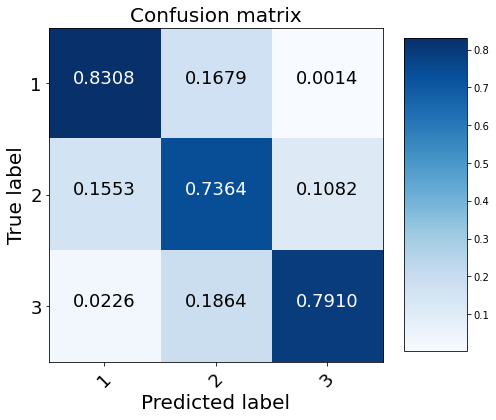

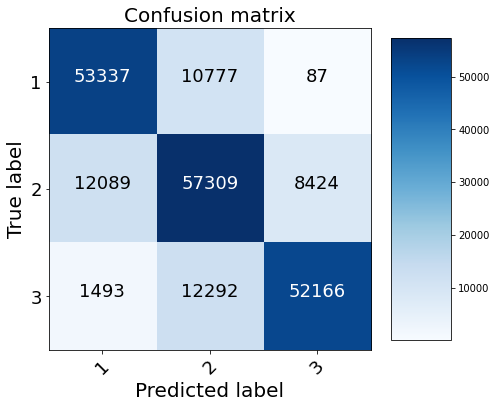

In [11]:

y_pred=np.argmax(testX_pred_L, axis=1)
y_test=np.argmax(testY, axis=1)
cm = confusion_matrix(y_test, y_pred)
class_names = ['1','2','3']
plot_confusion_matrix(cm, class_names)
plot_confusion_matrix(cm, class_names, normalize=False)

In [13]:
import joblib

joblib.dump(RF_model, 'trained_model/RF_model.pkl')

['trained_model/RF_model.pkl']

# ------------
